In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt



## Data Loading

In [5]:
dataset = xr.open_dataset("../data/data_10.nc")
dataset

<xarray.Dataset> Size: 220MB
Dimensions:           (samples: 670, time_steps: 2560, channels: 16)
Coordinates:
  * samples           (samples) int64 5kB 0 1 2 3 4 5 ... 665 666 667 668 669
Dimensions without coordinates: time_steps, channels
Data variables:
    signal            (samples, time_steps, channels) float64 220MB ...
    label             (samples) int64 5kB ...
    segment           (samples) int64 5kB ...
    patient_name      (samples) <U8 21kB ...
    recording_number  (samples) int64 5kB ...

In [8]:
# get sample index
df = dataset[["label", "patient_name", "samples"]].to_dataframe()
df.value_counts().sort_index()

label  patient_name
0      amer            85
       dhelal          84
       mahmud          44
       omran           64
1      bader           64
       mohammed        99
       nour            71
       saud            46
       shahad          38
       yahia           75
Name: count, dtype: int64

In [ ]:
# ---- SAMPLING METHOD 1
test_patients = [
    # autism

    # normal

]

# split train and test persons
test_dataset = dataset.sel(
    samples=df[df["patient_names"].isin(test_patients)].index.tolist()
)
train_dataset = dataset.sel(
    samples=df[~df["patient_names"].isin(test_patients)].index.tolist()
)

# get Xy for train
X_train = train_dataset["signal"].to_numpy()
y_train = train_dataset["label"].to_numpy()

# get Xy for test
X_test = test_dataset["signal"].to_numpy()
y_test = test_dataset["label"].to_numpy()

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
## ---- SAMPLING METHOD 2
# get Xy
X = dataset["signal"].to_numpy()
y = dataset["label"].to_numpy()

# stratified random sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

In [11]:
# print statistics
print("Train:", X_train.shape, y_train.shape)
print("Classdist:", np.unique(y_train, return_counts=True))

print("Test:", X_test.shape, y_test.shape)
print("Classdist:", np.unique(y_test, return_counts=True))

Train: (448, 2560, 16) (448,)
Classdist: (array([0, 1]), array([185, 263]))
Test: (222, 2560, 16) (222,)
Classdist: (array([0, 1]), array([ 92, 130]))


## CNN 1D Classification

In [3]:
import tensorflow as tf

2024-09-03 10:50:58.205570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 10:50:58.280420: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 10:50:58.302333: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-03 10:50:58.444472: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 10:50:59.614633: W tensorflow/compiler/tf2

In [12]:
# create model

inputs = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2],))

x = tf.keras.layers.Conv1D(32, kernel_size=8, strides=2, activation="relu", use_bias=False)(inputs)
# x = tf.keras.layers.Conv1D(32, kernel_size=6, strides=2, activation="relu", use_bias=False)(inputs)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

I0000 00:00:1725335861.034796   31904 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725335861.196759   31904 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725335861.196807   31904 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725335861.199439   31904 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725335861.199512   31904 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2560, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1277, 32)       │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,913 (152.00 KB)

 Trainable params: 38,913 (152.00 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # loss=tf.keras.losses.BinaryFocalCrossentropy(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
    #   tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
])

In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test), callbacks=[es])

Epoch 1/100


I0000 00:00:1725335892.306944   33537 service.cc:146] XLA service 0x7f02d802a8e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725335892.306979   33537 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-09-03 10:58:12.370470: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-03 10:58:12.530635: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


15/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5563 - auc: 0.5613 - fn: 29.5333 - fp: 27.5333 - loss: 1.5089 - precision: 0.6319 - recall: 0.6210 - tn: 25.5333 - tp: 45.4000      

I0000 00:00:1725335895.068172   33537 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.5748 - auc: 0.5832 - fn: 47.0345 - fp: 52.2069 - loss: 1.3286 - precision: 0.6395 - recall: 0.6526 - tn: 46.2414 - tp: 93.9655 - val_accuracy: 0.6712 - val_auc: 0.7280 - val_fn: 14.0000 - val_fp: 59.0000 - val_loss: 0.6090 - val_precision: 0.6629 - val_recall: 0.8923 - val_tn: 33.0000 - val_tp: 116.0000
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6877 - auc: 0.7941 - fn: 27.5862 - fp: 44.8276 - loss: 0.5319 - precision: 0.7069 - recall: 0.7712 - tn: 55.5172 - tp: 111.5172 - val_accuracy: 0.6982 - val_auc: 0.8370 - val_fn: 1.0000 - val_fp: 66.0000 - val_loss: 0.5740 - val_precision: 0.6615 - val_recall: 0.9923 - val_tn: 26.0000 - val_tp: 129.0000
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6960 - auc: 0.8019 - fn: 19.3103 - fp: 47.3793 - loss: 0.5391 - precision: 0.6944 - recall: 0.8761 - tn: 51.1724 - tp: 121.5862 - val_accuracy: 0.6892 - val_auc: 0.8062 - val_fn: 58.0000 - val_fp: 11.0000 

## Evaluation

In [16]:
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [15]:
model.evaluate(X_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.8866 - auc: 0.9302 - fn: 15.7500 - fp: 1.0000 - loss: 1.0736 - precision: 0.9893 - recall: 0.8017 - tn: 58.7500 - tp: 64.0000


[1.4911452531814575,
 102.0,
 2.0,
 90.0,
 28.0,
 0.8648648858070374,
 0.9807692170143127,
 0.7846153974533081,
 0.9344481825828552]

In [20]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

print("MCC:", np.round(matthews_corrcoef(y_test, y_pred), 4))
print("Accuracy:", np.round(accuracy_score(y_test, y_pred), 4))
print("Precision:", np.round(precision_score(y_test, y_pred), 4))
print("Recall:", np.round(recall_score(y_test, y_pred), 4))
print("F1:", np.round(f1_score(y_test, y_pred), 4))

print(classification_report(y_test, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MCC: 0.7531
Accuracy: 0.8649
Precision: 0.9808
Recall: 0.7846
F1: 0.8718
              precision    recall  f1-score   support

           0       0.76      0.98      0.86        92
           1       0.98      0.78      0.87       130

    accuracy                           0.86       222
   macro avg       0.87      0.88      0.86       222
weighted avg       0.89      0.86      0.87       222



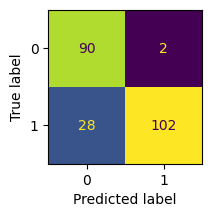

In [21]:
fig, ax = plt.subplots(figsize=(2, 2))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)